In [25]:
import matplotlib.pyplot as plt
import torch
from torch.nn import Conv2d, CrossEntropyLoss, Linear, MaxPool2d, Module
from torch.nn.functional import relu
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor

In [26]:
# Define the transformation to apply to the data
transform = Compose([ToTensor()])

# Load the MNIST dataset
trainset = MNIST("mnist_data", download=True, train=True, transform=transform)
testset = MNIST("mnist_data", download=True, train=False, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Define the data loaders for the training, validation, and testing sets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

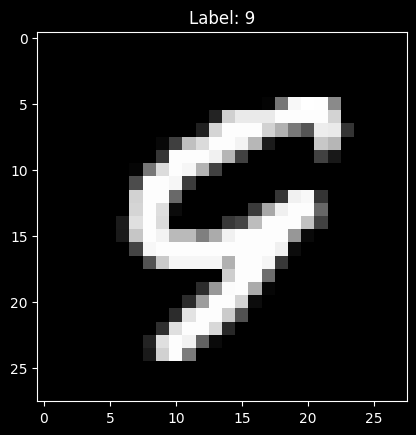

In [27]:
# Get a random image from the training set
image, label = trainset[0]

# Plot the image
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [28]:
device = torch.device("mps")

In [29]:
class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = Linear(64 * 7 * 7, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool(x)
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [30]:
model = ConvNet().to(device)

In [31]:
# Define the loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 5
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs = inputs.to(
            device, dtype=torch.float32
        )  # convert input tensor to float32
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Print statistics
        if i % 100 == 99:
            # Compute validation accuracy and loss
            correct_val = 0
            total_val = 0
            val_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            print(
                f"[Epoch {epoch + 1}, Batch {i + 1}] "
                f"Train Loss: {running_loss / 100:.3f} "
                f"Train Acc: {100 * correct_train / total_train:.2f}% "
                f"Val Loss: {val_loss / len(valloader):.3f} "
                f"Val Acc: {100 * correct_val / total_val:.2f}%"
            )
            running_loss = 0.0
            correct_train = 0
            total_train = 0

[Epoch 1, Batch 100] Train Loss: 0.720 Train Acc: 78.39% Val Loss: 0.299 Val Acc: 90.86%
[Epoch 1, Batch 200] Train Loss: 0.205 Train Acc: 93.73% Val Loss: 0.164 Val Acc: 95.17%
[Epoch 1, Batch 300] Train Loss: 0.133 Train Acc: 95.94% Val Loss: 0.120 Val Acc: 96.67%
[Epoch 1, Batch 400] Train Loss: 0.111 Train Acc: 96.75% Val Loss: 0.101 Val Acc: 96.93%
[Epoch 1, Batch 500] Train Loss: 0.109 Train Acc: 96.83% Val Loss: 0.088 Val Acc: 97.26%
[Epoch 1, Batch 600] Train Loss: 0.085 Train Acc: 97.50% Val Loss: 0.079 Val Acc: 97.57%
[Epoch 1, Batch 700] Train Loss: 0.071 Train Acc: 97.67% Val Loss: 0.070 Val Acc: 97.86%
[Epoch 2, Batch 100] Train Loss: 0.059 Train Acc: 98.16% Val Loss: 0.107 Val Acc: 96.90%
[Epoch 2, Batch 200] Train Loss: 0.076 Train Acc: 97.86% Val Loss: 0.064 Val Acc: 98.04%
[Epoch 2, Batch 300] Train Loss: 0.058 Train Acc: 98.22% Val Loss: 0.071 Val Acc: 97.85%
[Epoch 2, Batch 400] Train Loss: 0.049 Train Acc: 98.50% Val Loss: 0.058 Val Acc: 98.29%
[Epoch 2, Batch 500] 

In [32]:
# Compute test accuracy and loss
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(
    f"Test Loss: {test_loss / len(testloader):.3f} "
    f"Test Acc: {100 * correct_test / total_test:.2f}%"
)

Test Loss: 0.032 Test Acc: 99.03%
